
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## RBFs reconstruction and validation of historical and synthetic data

inputs required: 
  * Historical offshore waves
  * Synthetic offshore waves - emulator output
  * Sea and swell SWAN simulated  cases from ***Notebook 02_02***

in this notebook:
  * Offshore validation - checking
  * RBF reconstruction historical storms
  * RBF reconstruction simulated storms
  * Validation: AWAC measurement - Synthetic and historical histograms - Extremes


### Workflow:

<div>
<img src="resources/nb02_03.png" width="400px">
</div>



### TODO
- VALIDACION VS BOYA AWAC + PLOTEO
- ¿PUEDE ACELERARSE RBF? ¿ESTAN AJUSTANDOSE VARIAS VECES LA MISMA?

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Reconstruction, RBF_Validation
from teslakit.waves import Aggregate_WavesFamilies, AWL
from teslakit.climate_emulator import Climate_Emulator

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation
from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')

# Load Climate Emulator
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()


In [3]:
# input files: dataset, subset (MDA classification), and target (SWAN simulations output)

# sea 
wvs_sea_dataset_sim = db.Load_NEARSHORE_SIM_sea()
wvs_sea_dataset_hist = db.Load_NEARSHORE_HIST_sea()
wvs_sea_subset = db.Load_NEARSHORE_MDA_sea()
wvs_sea_target = db.Load_NEARSHORE_TARGET_sea()

# swells 
wvs_swell_dataset_sim = db.Load_NEARSHORE_SIM_swell()
wvs_swell_dataset_hist = db.Load_NEARSHORE_HIST_swell()
wvs_swell_subset = db.Load_NEARSHORE_MDA_swell()
wvs_swell_target = db.Load_NEARSHORE_TARGET_swell()

# keep datasets n_sim column
sea_n_sim = wvs_sea_dataset_sim['n_sim']
swl_n_sim = wvs_swell_dataset_sim['n_sim']


# remove nans (if any) from subset and target
def fix_target_nans(subset, target):
    'remove NaN data indexes from subset and target. RBF does not handle NaNs'
    
    r_nan = target.isnull().any(axis=1)  # find any row with nans

    if r_nan.any():
        # log
        print('remove nan data found at target:')
        print(target[r_nan])
        
        # clean data
        target = target[~r_nan]
        subset = subset[~r_nan]
        
    return subset, target

wvs_sea_subset, wvs_sea_target = fix_target_nans(wvs_sea_subset, wvs_sea_target)
wvs_swell_subset, wvs_swell_target = fix_target_nans(wvs_swell_subset, wvs_swell_target)


# ensure dataset and subset have same variables and column order
vns_ds = ['hs', 'tp', 'dir']

wvs_sea_dataset_sim = wvs_sea_dataset_sim[vns_ds].values
wvs_sea_dataset_hist = wvs_sea_dataset_hist[vns_ds].values
wvs_sea_subset = wvs_sea_subset[vns_ds].values

wvs_swell_dataset_sim = wvs_swell_dataset_sim[vns_ds].values
wvs_swell_dataset_hist = wvs_swell_dataset_hist[vns_ds].values
wvs_swell_subset = wvs_swell_subset[vns_ds].values


# select target variables
vns_tgt = ['Hsig', 'TPsmoo', 'Dir']

wvs_sea_target = wvs_sea_target[vns_tgt].values
wvs_swell_target = wvs_swell_target[vns_tgt].values


remove nan data found at target:
         lat       lon  Hsig  Tm02  Dir  Dspr  TPsmoo
case                                                 
49    9.4165  167.4679   0.0   NaN  NaN   NaN     NaN


In [4]:
# RBF settings

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]      # scalar (hs, tp)
ix_directional_subset = [2]   # directional (dir)

# target - scalar / directional indexes
ix_scalar_target = [0,1]      # scalar (Hsig, Tpsmoo, Dir)
ix_directional_target = [2]   # directional (Dir)


# RBF wrappers 
def RBF_Reconstruction_sea(dataset_input):
    
    return RBF_Reconstruction(
    wvs_sea_subset, ix_scalar_subset, ix_directional_subset,
    wvs_sea_target, ix_scalar_target, ix_directional_target,
    dataset_input)

def RBF_Reconstruction_swell(dataset_input):
    
    return RBF_Reconstruction(
    wvs_swell_subset, ix_scalar_subset, ix_directional_subset,
    wvs_swell_target, ix_scalar_target, ix_directional_target,
    dataset_input)

def RBF_Reconstruction_families(data):
   
    # sea
    vs = ['sea_Hs', 'sea_Tp', 'sea_Dir']
    data_sea = data[vs].to_dataframe().dropna()
    data_sea.drop(data_sea[(data_sea['sea_Dir'] >= 360)].index, inplace=True)  # fix sea_Dir >> 360 bug    
    rec_sea = RBF_Reconstruction_sea(data_sea.values)
    rec_sea = pd.DataFrame(data=rec_sea, columns=vs, index=data_sea.index)

    # swell 1
    vs = ['swell_1_Hs', 'swell_1_Tp', 'swell_1_Dir']
    data_swl_1 = data[vs].to_dataframe().dropna()
    rec_swl_1 = RBF_Reconstruction_swell(data_swl_1.values)
    rec_swl_1 = pd.DataFrame(data=rec_swl_1, columns=vs, index=data_swl_1.index)

    # swell 2
    vs = ['swell_2_Hs', 'swell_2_Tp', 'swell_2_Dir']
    data_swl_2 = data[vs].to_dataframe().dropna()
    rec_swl_2 = RBF_Reconstruction_swell(data_swl_2.values)
    rec_swl_2 = pd.DataFrame(data=rec_swl_2, columns=vs, index=data_swl_2.index)
    
    # join nearshore reconstructed data and parse to xarray.Dataset
    rec_waves = pd.concat([rec_sea, rec_swl_1, rec_swl_2], axis=1)

    return xr.Dataset.from_dataframe(rec_waves)
     


## RBF Reconstruct SEA Waves

In [5]:
# --------------------------------------
# RBF Interpolation

# Simulated SEA waves
#sea_rec_sim = RBF_Reconstruction_sea(wvs_sea_dataset_sim)
#df_sea_recon_sim = pd.DataFrame(data=sea_rec_sim, columns=vns_tgt)
#df_sea_recon_sim['n_sim'] = sea_n_sim  # keep n_sim value

# Historical SEA waves
#sea_rec_hist = RBF_Reconstruction_sea(wvs_sea_dataset_hist)
#df_sea_recon_hist = pd.DataFrame(data=sea_rec_hist, columns=vns_tgt)


# store data
#db.Save_NEARSHORE_RECONSTRUCTION_SIM_sea(df_sea_recon_sim)
#db.Save_NEARSHORE_RECONSTRUCTION_HIST_sea(df_sea_recon_hist)



## RBF Reconstruct SWELL Waves

In [6]:
# --------------------------------------
# RBF Interpolation

# Simulated SWELL waves
#swl_rec_sim = RBF_Reconstruction_swell(wvs_swell_dataset_sim)
#df_swl_recon_sim = pd.DataFrame(data=swl_rec_sim, columns=vns_tgt)
#df_swl_recon_sim['n_sim'] = swl_n_sim  # keep n_sim value

# Historical SWELL waves
#swl_rec_hist = RBF_Reconstruction_swell(wvs_swell_dataset_hist)
#df_swl_recon_hist = pd.DataFrame(data=swl_rec_hist, columns=vns_tgt)


# store data
#db.Save_NEARSHORE_RECONSTRUCTION_SIM_swell(df_swl_recon_sim)
#db.Save_NEARSHORE_RECONSTRUCTION_HIST_swell(df_swl_recon_hist)



## Load historical and simulated offshore waves

In [7]:
# Load climate emulator historical waves (storms)
WVS_hist = db.Load_HIST_Complete_storms()
WVS_hist['AWL'] = AWL(WVS_hist.Hs, WVS_hist.Tp) # calculate AWL


# Load cliamte emulator simulation waves (storms)
n_sims_DWTs = 10
l_WVS_sim = db.Load_SIM_Complete_storms(n_sims_DWTs)
for WVS_sim in l_WVS_sim: WVS_sim['AWL'] = AWL(WVS_sim.Hs, WVS_sim.Tp) # calculate AWL
    

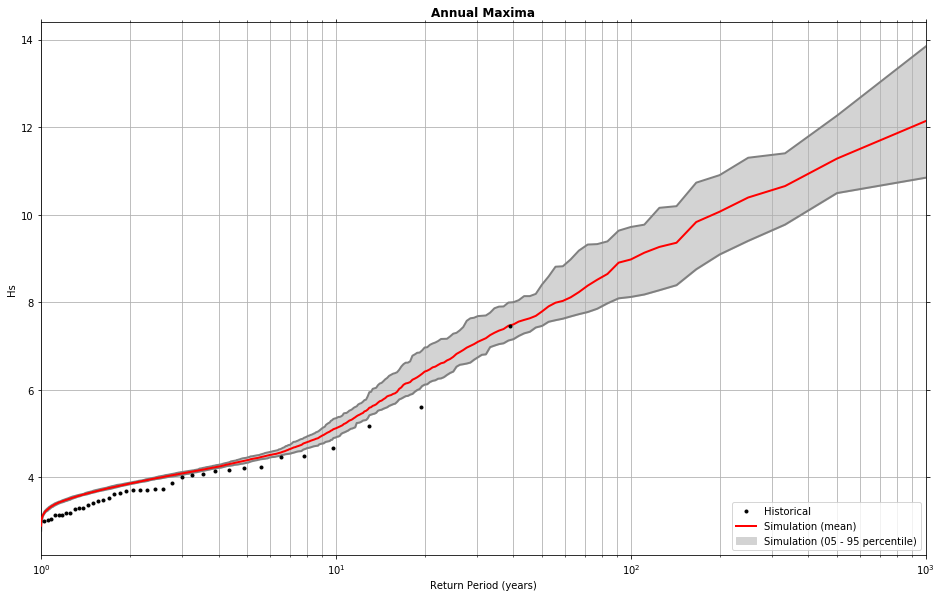

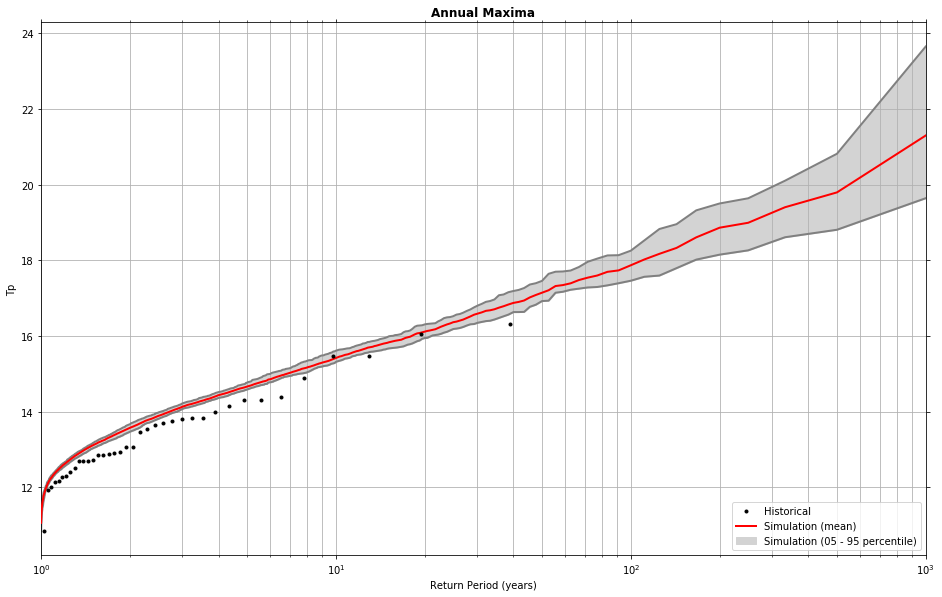

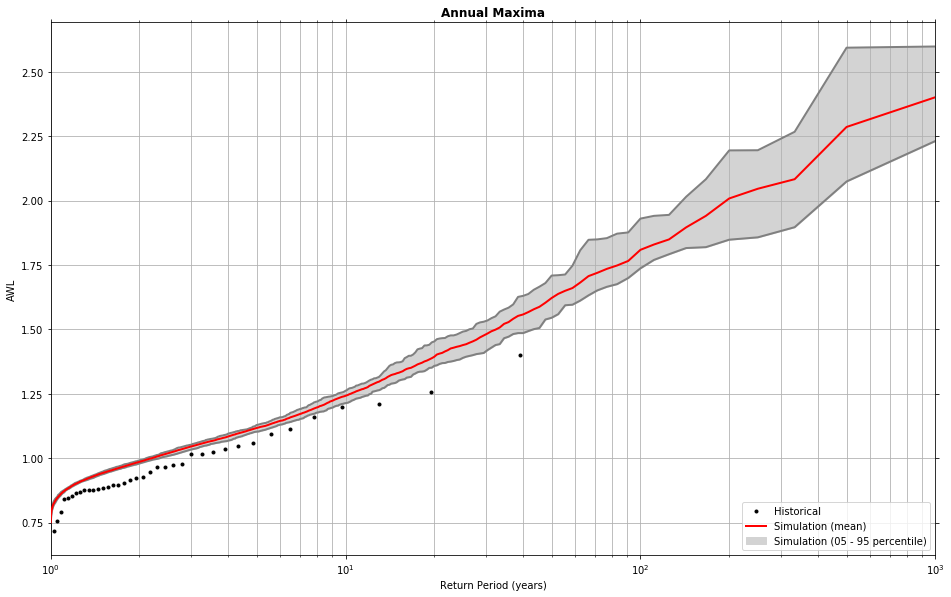

In [8]:
# compare historical and simulations annual maxima (for storms)

vns = ['Hs', 'Tp', 'AWL']
for vn in vns:

    # calculate Annual Maxima values for historical and simulated data
    hist_A = WVS_hist[vn].groupby('time.year').max(dim='time')
    sim_A = xr.concat([x[vn].groupby('time.year').max(dim='time') for x in l_WVS_sim], 'n_sim')

    # Return Period historical vs. simulations
    Plot_ReturnPeriodValidation(hist_A, sim_A);
    


## RBF Reconstruct Historical storms

In [9]:
# Reconstruct waves by families
WVS_HIST_rec = RBF_Reconstruction_families(WVS_hist)

# aggregate nearshore variables
WVS_a = Aggregate_WavesFamilies(WVS_HIST_rec)
WVS_HIST_rec = xr.merge([WVS_HIST_rec, WVS_a])

# calculate AWL
WVS_HIST_rec['AWL'] = AWL(WVS_HIST_rec.Hs, WVS_HIST_rec.Tp)

    
# store historical storms waves reconstruction
db.Save_NEARSHORE_RECONSTRUCTION_HIST_storms(WVS_HIST_rec)


ix_scalar: 0,  optimization: 71.95 | interpolation: 0.36
ix_scalar: 1,  optimization: 132.96 | interpolation: 0.38
ix_directional: 2,  optimization: 106.45 | interpolation: 0.65
ix_scalar: 0,  optimization: 47.06 | interpolation: 0.54
ix_scalar: 1,  optimization: 100.98 | interpolation: 0.49
ix_directional: 2,  optimization: 100.54 | interpolation: 0.96
ix_scalar: 0,  optimization: 46.09 | interpolation: 0.53
ix_scalar: 1,  optimization: 102.95 | interpolation: 0.62
ix_directional: 2,  optimization: 104.50 | interpolation: 1.07



## RBF Reconstruct Simulation storms

In [10]:

l_sims_rec = []
for data in l_WVS_sim:
    
    # Reconstruct waves by families
    WVS_SIM_rec = RBF_Reconstruction_families(data)
    
    # aggregate nearshore variables
    WVS_a = Aggregate_WavesFamilies(WVS_SIM_rec)
    WVS_SIM_rec = xr.merge([WVS_SIM_rec, WVS_a])
    
    # calculate AWL
    WVS_SIM_rec['AWL'] = AWL(WVS_SIM_rec.Hs, WVS_SIM_rec.Tp)

    l_sims_rec.append(WVS_SIM_rec)
    
    
# store simulations storms waves reconstruction
db.Save_NEARSHORE_RECONSTRUCTION_SIM_storms(l_sims_rec)


ix_scalar: 0,  optimization: 50.81 | interpolation: 5.03
ix_scalar: 1,  optimization: 109.07 | interpolation: 5.21
ix_directional: 2,  optimization: 99.61 | interpolation: 11.32
ix_scalar: 0,  optimization: 48.66 | interpolation: 13.91
ix_scalar: 1,  optimization: 98.87 | interpolation: 14.03
ix_directional: 2,  optimization: 115.72 | interpolation: 27.80
ix_scalar: 0,  optimization: 46.53 | interpolation: 14.39
ix_scalar: 1,  optimization: 93.99 | interpolation: 14.58
ix_directional: 2,  optimization: 99.13 | interpolation: 29.78
ix_scalar: 0,  optimization: 56.22 | interpolation: 6.04
ix_scalar: 1,  optimization: 109.60 | interpolation: 5.39
ix_directional: 2,  optimization: 98.75 | interpolation: 9.54
ix_scalar: 0,  optimization: 48.26 | interpolation: 13.49
ix_scalar: 1,  optimization: 96.17 | interpolation: 14.09
ix_directional: 2,  optimization: 109.18 | interpolation: 27.76
ix_scalar: 0,  optimization: 45.06 | interpolation: 14.88
ix_scalar: 1,  optimization: 96.19 | interpolati

## Methodology Validation: Buoy comparison

In [11]:
# TODO: validate with AWAC + plot
# TODO 02b_Validation AWAC.ipynb mejor



## Methodology Validation: Historical - Simulation Waves Families Comparison

SIM n. 0


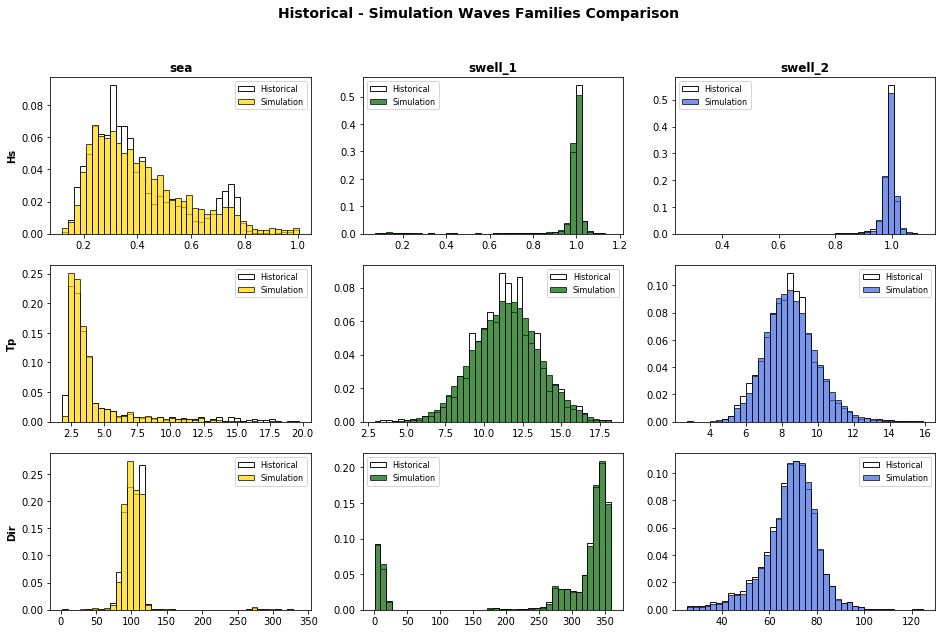

SIM n. 1


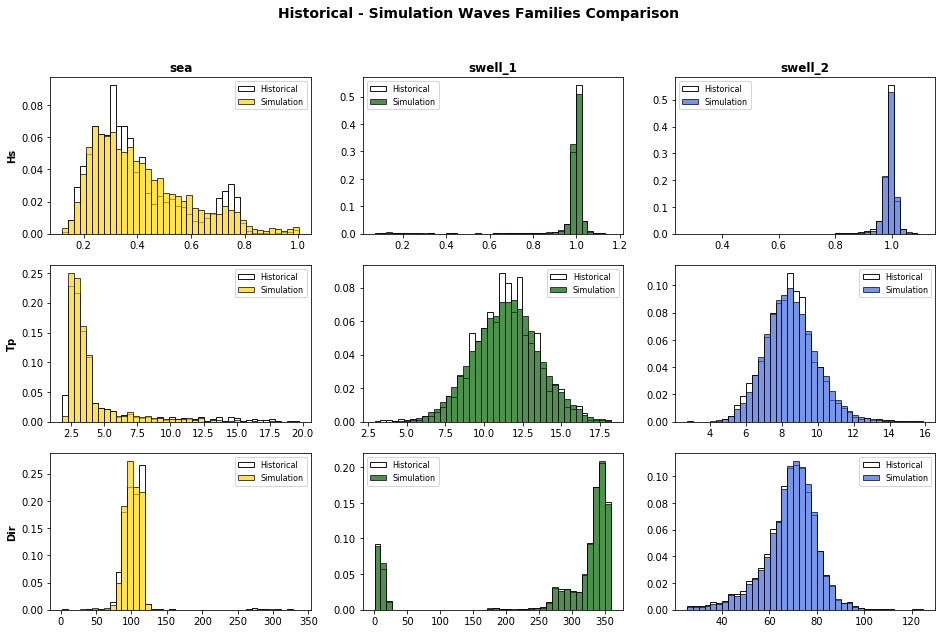

SIM n. 2


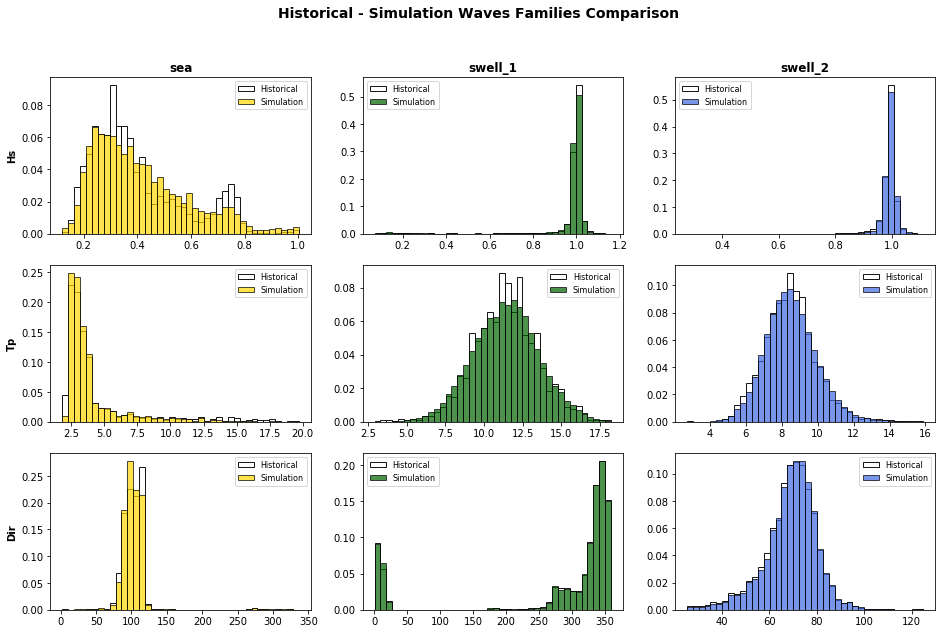

SIM n. 3


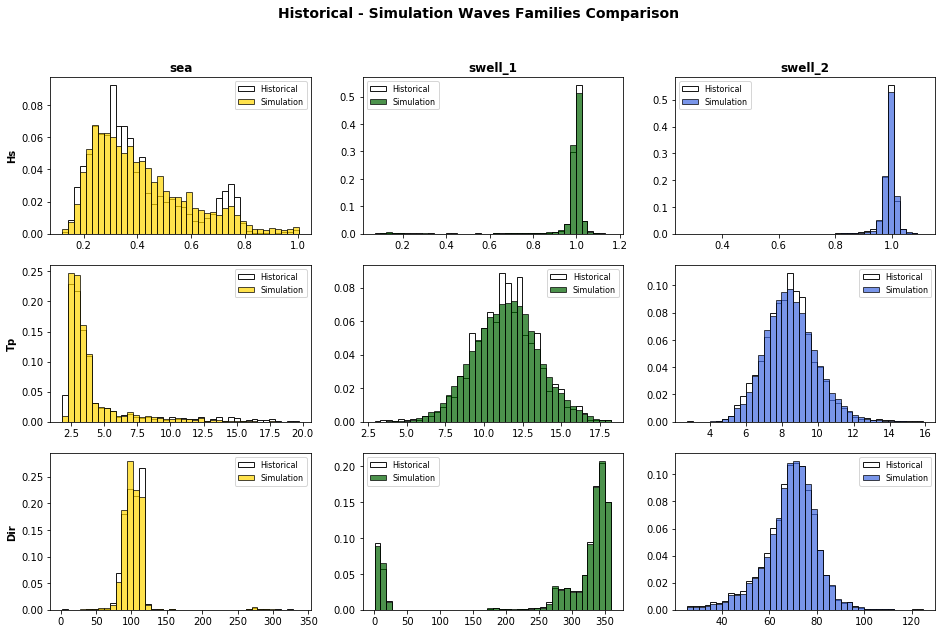

SIM n. 4


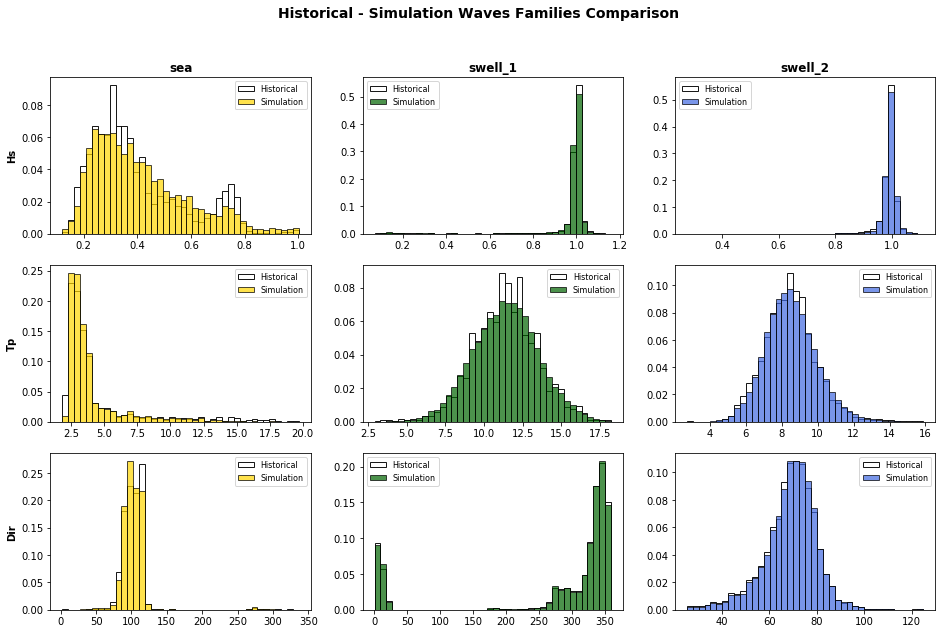

SIM n. 5


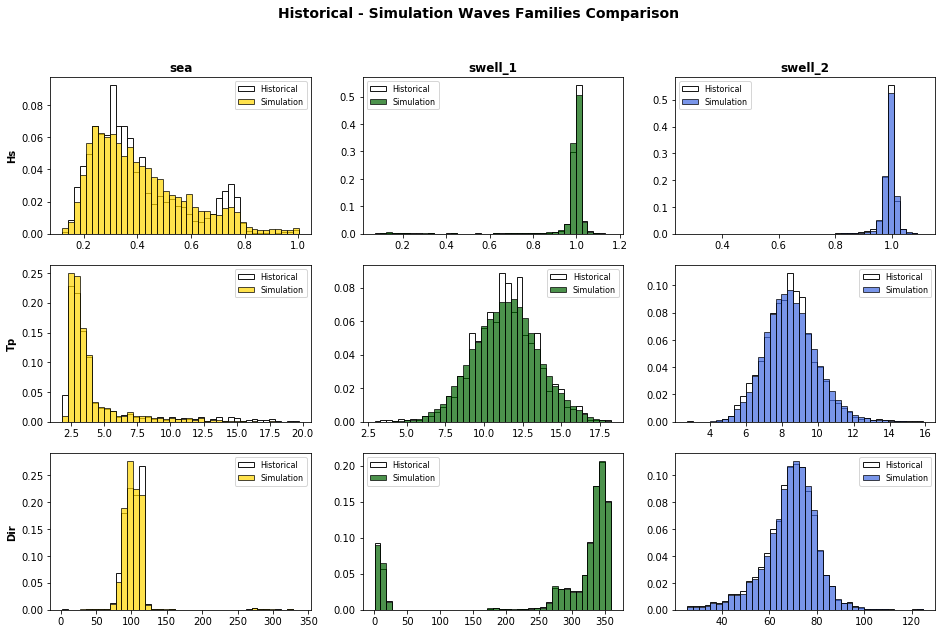

SIM n. 6


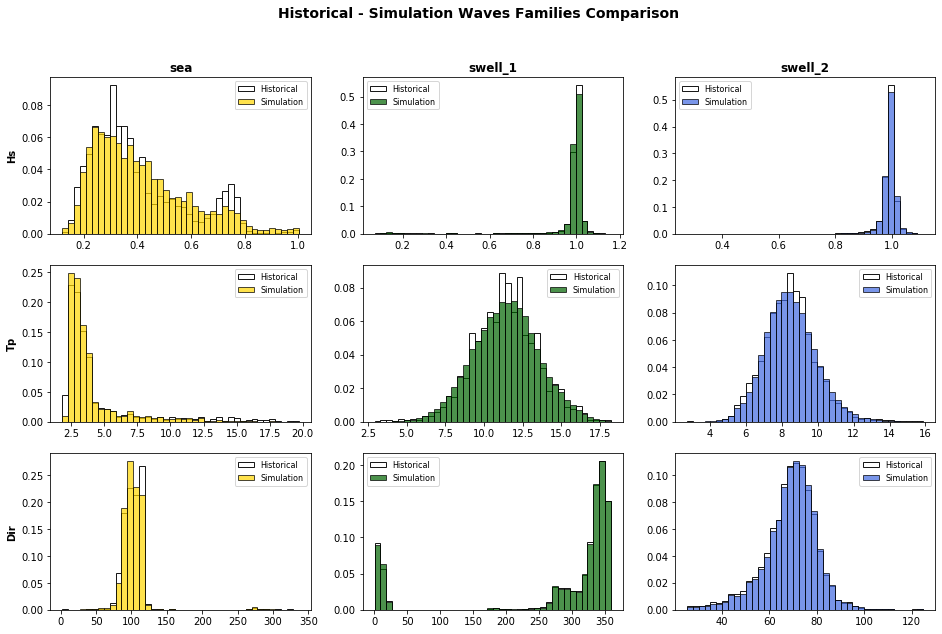

SIM n. 7


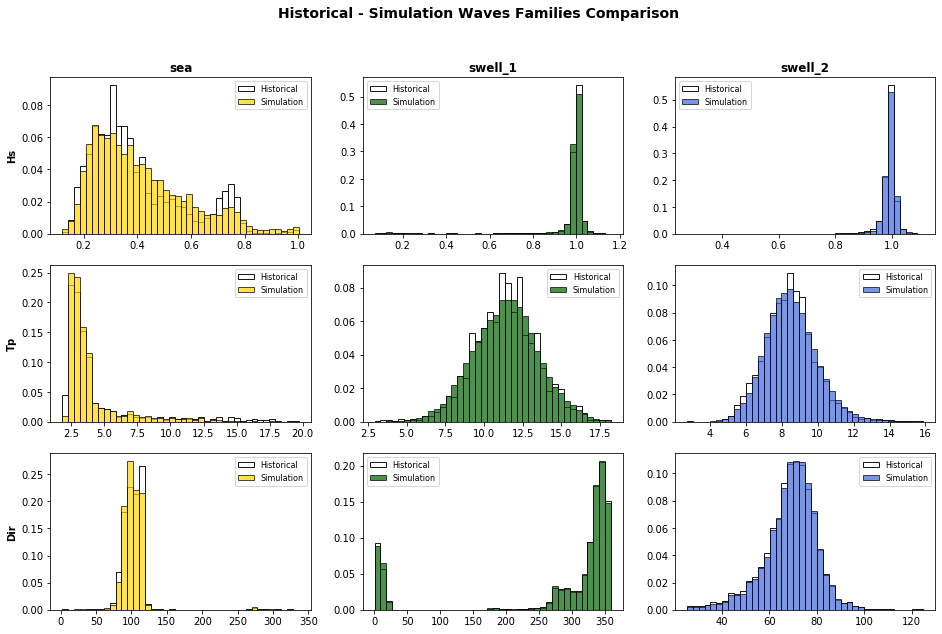

SIM n. 8


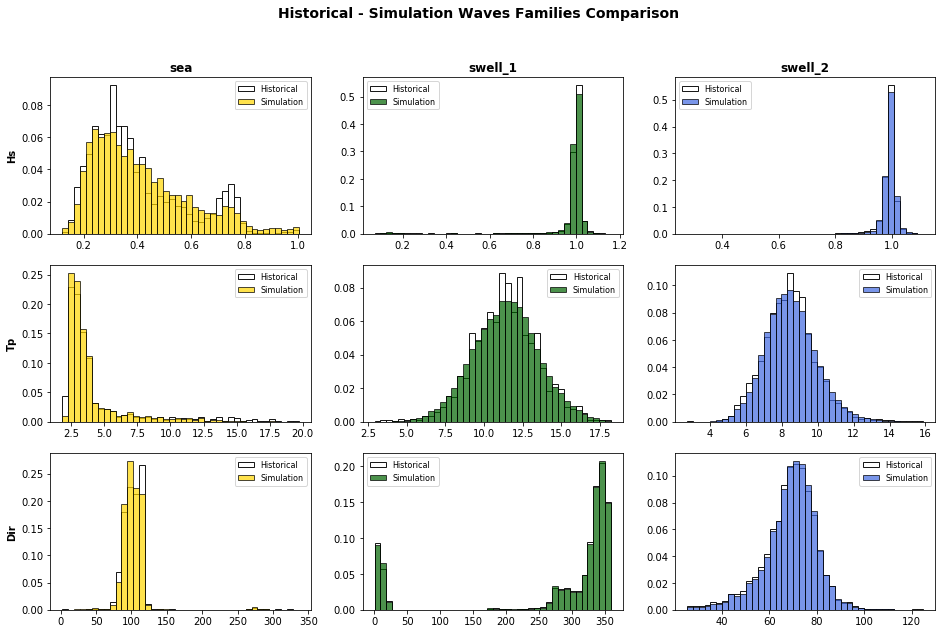

SIM n. 9


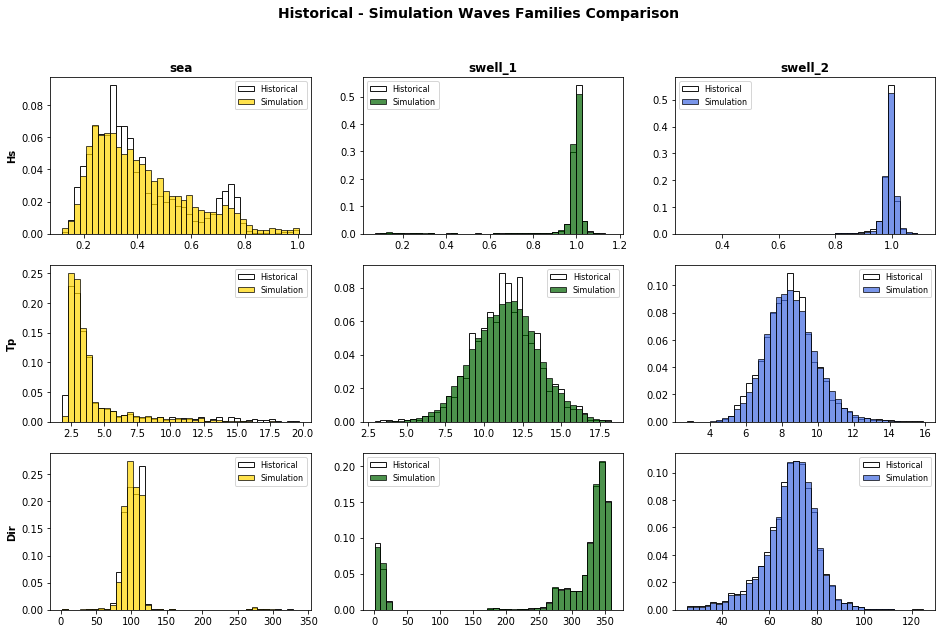

In [12]:
for s, WVS_sim_rec in enumerate(l_sims_rec):
    
    print('SIM n. {0}'.format(s))
    Plot_Waves_Histogram_FitSim(WVS_HIST_rec, WVS_sim_rec);
    


## Methodology Validation: Historical - Simulation Annual Maxima

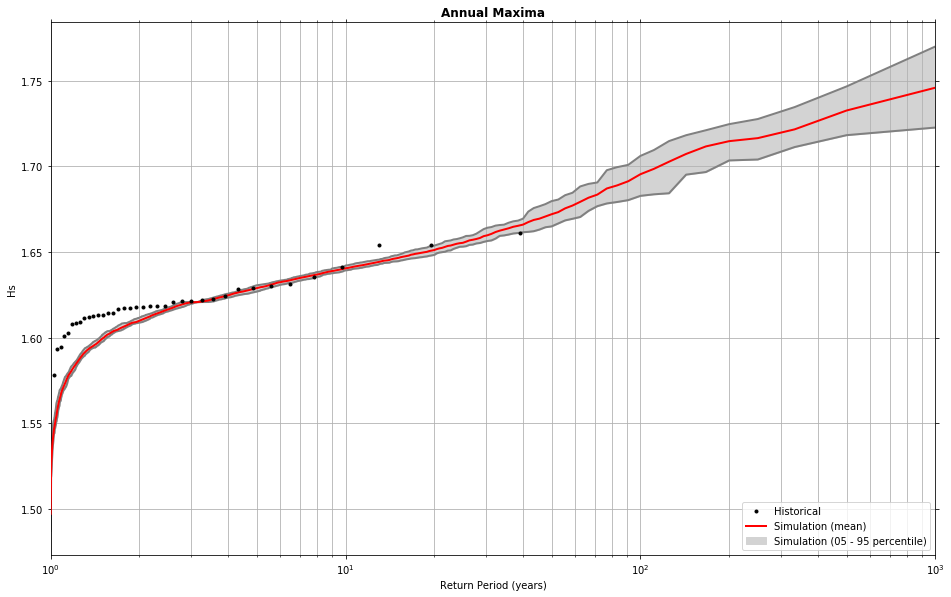

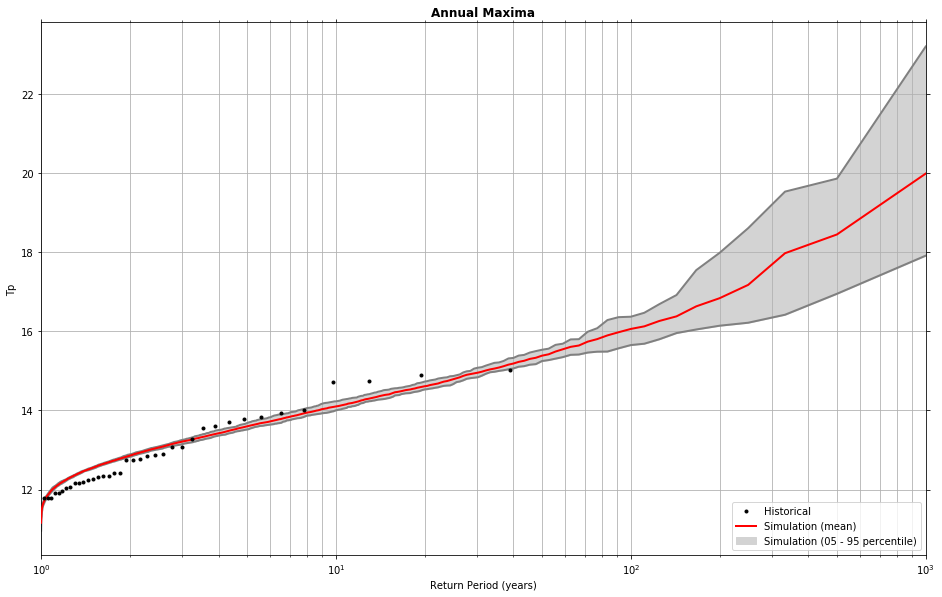

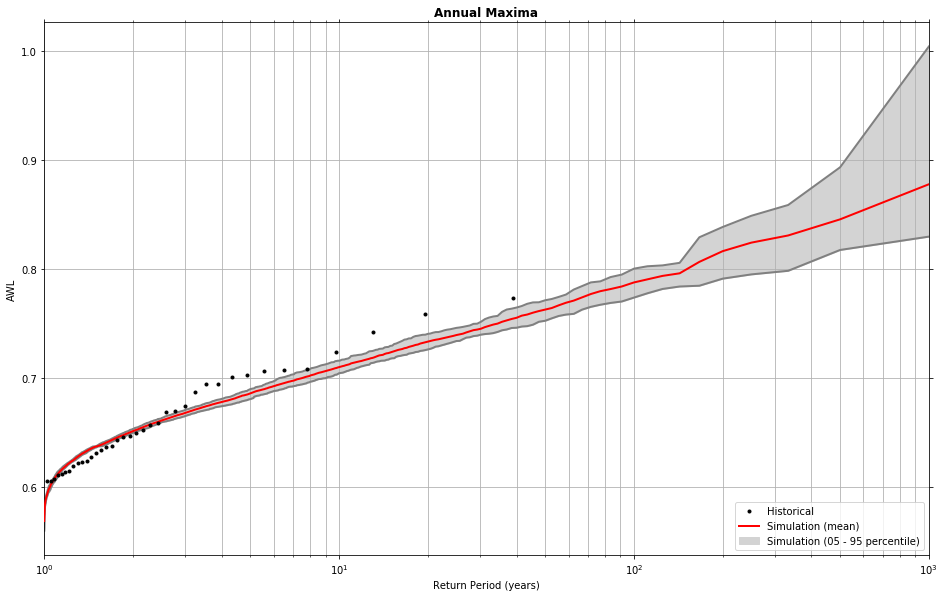

In [13]:
# compare historical and simulations reconstruction vars. annual maxima

vns = ['Hs', 'Tp', 'AWL']
for vn in vns:

    # calculate Annual Maxima values for historical and simulated data
    hist_A = WVS_HIST_rec[vn].groupby('time.year').max(dim='time')
    sim_A = xr.concat([x[vn].groupby('time.year').max(dim='time') for x in l_sims_rec], 'n_sim')

    # Return Period historical vs. simulations
    Plot_ReturnPeriodValidation(hist_A, sim_A);
    
